# Conditionnal Bernoulli

## question 1


Let $N$ be an integer, and consider the probability vector $p = (p_1, p_2, \dots, p_N)$ where each $p_i$ belongs to the interval $(0,1)$ for  $i = 1, \dots, N$.  
The sample space is given by $\Omega = \{0,1\}^N$ and $\Omega' := \left\{ x \in \{0,1\}^N \mid \sum_{i=1}^N x_i = I \right\} $.  
We assume that $I$ is an integer satisfying $I \leq \frac{N}{2}$.  
Let $g$ be the probability density function of the random vector  
$$
(X_1, \dots, X_N)
$$
where the $X_i$ are independent Bernoulli random variables $X_i \sim \mathsf{B}(p_i).$  
Finally, let $f$ be the probability density function of  
$$
(X_1, \dots, X_N) \sim \mathsf{CB}(p, I).
$$  

We will use the following proposition from the lecture :
> Let $f$, $g$ be probability density functions (PDFs) such that the support of $g$ contains the support of $f$ and
> 
> $$
> f \leq M g \quad \text{with } M \geq 1.
> $$
> 
> ### Accept-Reject Algorithm
> Repeat:  
> 1. Draw $X \sim g$ and $U \sim U[0,1]$.  
> 2. Until $U \leq \frac{f(X)}{M g(X)}$.
> 
> ### Properties:
> - $X \sim f$ 
> - The number of draws until acceptance follows a **Geometric** distribution:  
>   
>   $$
>   \text{Geometric}(1/M).
>   $$  

We choose the smallest possible $M$ in order to have as little draws as possible 
$$
M = \underset{x \in \Omega'}{\sup} \; \frac{f(x)}{g(x)}
$$

<u>Remark</u> : 

Because $N$ is fixed, that's actually a max. 

$$ M = \underset{x \in \Omega'}{\max} \; \frac{f(x)}{g(x)}$$

### Simple rejection algorithm

In [1]:
from collections import deque
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import geom
import time
from scipy.stats import chisquare
from scipy.stats import qmc

from source import *

Although theoritically this algorithm sample from $CB(p,I)$ we can also check empirically that this algorithm does sample from $CB(p,I)$. To do this we used the $\chi^2$ test of adequation with null hypothesis that the sample follows $CB(p,I)$ with signifiance level of 10%.

In [2]:
N = 10
I = 4
p = np.random.uniform(0, 1, N)
sampler = rejection_sampler(p, I)
sampler.sample_generator(1000)
p_value = sampler.chi_squared_adequation()

Pour le test du Chi2 avec hypothèse nulle H0 = 'notre sample suit une loi Conditionnal Bernoulli de paramètres (p,I)'
statistique du chi2 : 242.66216059922507
p-valeur : 0.0550493943115081
l'hypothèse nulle est rejeté à 10%


The result coherent, we have a sampler from $CB(p,I)$ We can then study the law that the p-value of this test follows. To do so we plotted the empirical density of the p-value of the $\chi^2$ test follows.

In [3]:
s =[]
for i in range(10000):
    sampler.sample_generator(250)
    p_value = sampler.chi_squared_adequation(False)
    s.append(p_value)


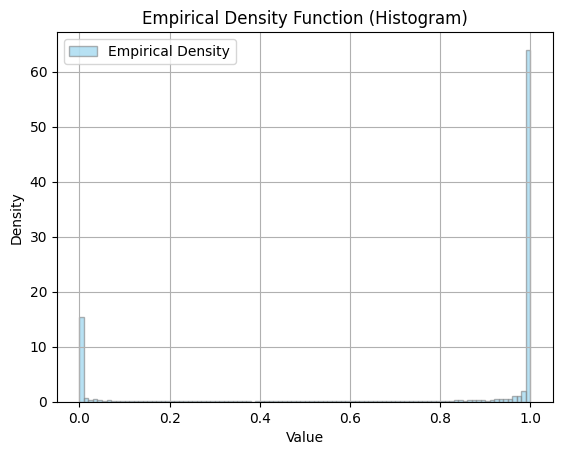

In [4]:

heights, bin_edges, patches = plt.hist(s,bins = 100, density=True, alpha=0.6,
                                       color='skyblue', edgecolor='gray', label='Empirical Density')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Empirical Density Function (Histogram)')
plt.grid(True)
plt.legend()
plt.show()


From looking at this density, it seems the p-value of the $\chi^2$ test follows $a * \delta_0 + b* \delta_1$ avec $a+b = 1$ et $a<b$ The following code lets us approximate $a$ and $b$.

In [5]:
heights, bin_edges, patches = plt.hist(s, bins=1000, density=True, alpha=0.6,
                                       color='skyblue', edgecolor='gray', label='Empirical Density')
plt.close()
# Compute bin widths
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Area = height * width
first_bin_area = heights[0] * bin_widths[0]
last_bin_area = heights[-1] * bin_widths[-1]
print("a:", first_bin_area)
print("b:", last_bin_area)

a: 0.1366
b: 0.5809


### Main drawback of algorithm

The main drawback of this approach is that it has a great time complexity. Indeed, the number of draws before acceptance of a sample follows a geometric laws of parameter $1/M$ so we have a sampling time in $O(M)$. The following graph, showcasing the empirical density of the number of draws before acceptance against the theoritical density of $Geom(1/M)$ show that the number of draws before acceptance does follow this law empirically. With our implementation, we choose the smallest possible $M$. This makes it so that the sampling is the quickest possible but at the initial cost of calculation of $M$. With our implementation the initial calculation of $M$ has a time complexity of $O(C_I^N)$. 



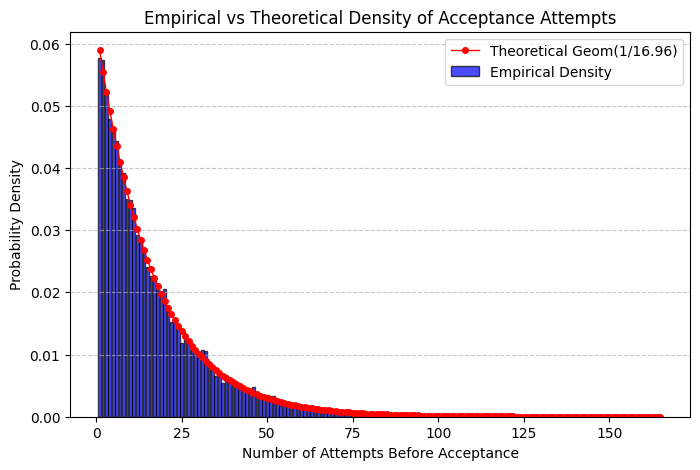

In [6]:
N = 13
I = 4
p = np.random.uniform(0, 1, N)
sampler = rejection_sampler(p, I)
sampler.sample_generator(20000)
sampler.plot_acceptance_density()

As said, previously, the sampling is done $O(M)$ However, we do not know à priori the value of $M$ because it's a function of $(p_1, \dots, p_N, I)$. In the following passage, we will show that:
 - $M$ tends to grow as $N$ grows (for a fixed $I$)
 - the variability of $M$ grows exponentially as $N$ grows (which is to be expected as we add degrees of liberty in the function)
 - $M$ is not monotonic in $I$ (for a fixed $p$) in particular  we have the smallest $M$ as $I \approx \sum_i p_i$

#### Evolution of M with respect to N

To study the evolution of M with respect to $N$, for a $I$ we will take different $(p_1,\dots,p_N)$ by drawing each $p_i$ indepdantly and uniformly from $(0,1)$ times and then calculate $M$ for these $p$s.

The following boxplot for $I=3$ show the general dynamic of $M$. $M$ increase as $N$ increase (we can see that by looking at the median of $M$). We also note that for a given $(N,I)$ the repartition of $M$ is skewed (with positive skewness).

/tmp/ipykernel_3788/4270680876.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values], showfliers=False, showmeans=False)


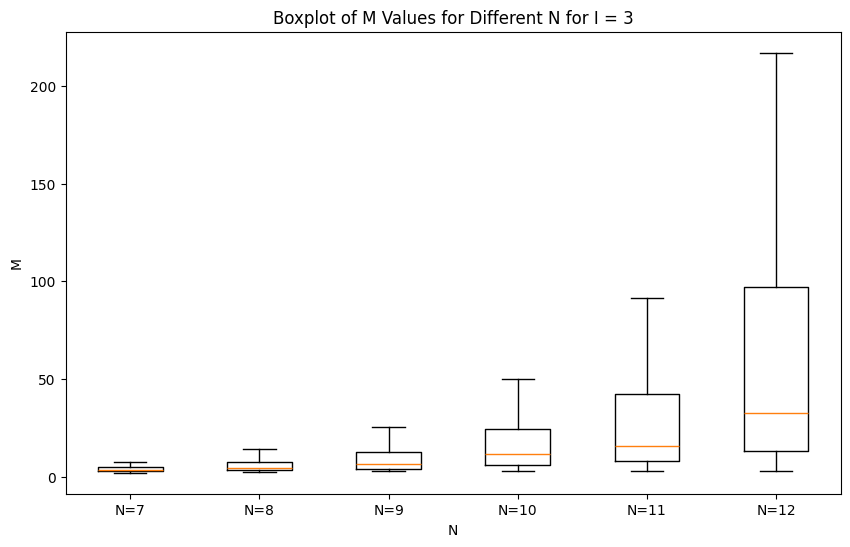

In [7]:
I = 3
num_samples = 500  # Number of samples to run
N_values = range(7,13)  # Different values for N
M_values_all = []  # To hold M values for each N

# Collect M values across multiple samples for different N
for N in N_values:
    M_values = []
    for _ in range(num_samples):
        p = np.random.uniform(0, 1, N)  # Generate random probabilities p
        sampler = rejection_sampler(p, I)
        M_values.append(sampler.M)
    M_values_all.append(M_values)

# Create a boxplot for each N
plt.figure(figsize=(10, 6))
plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values], showfliers=False, showmeans=False)
plt.title(f'Boxplot of M Values for Different N for I = {I}')
plt.ylabel('M')
plt.xlabel('N')
plt.show()

Furthermore the variability of $M$ also increase exponentially as $N$. We looked at the interquartile range and noted that it increased at an exponential rate of approximately $1.2$ for $I=3$

In [8]:
for i in range(len(M_values_all)-1):
    iqr_1 = np.percentile(M_values_all[i], 75) - np.percentile(M_values_all[i], 25) 
    iqr_2 = np.percentile(M_values_all[i+1], 75) - np.percentile(M_values_all[i+1], 25) 
    print(f"growth rate of interquartile range between N = {i+7} and N= {i+8} of {round((iqr_2-iqr_1)/iqr_1,3)}")

growth rate of interquartile range between N = 7 and N= 8 of 1.506
growth rate of interquartile range between N = 8 and N= 9 of 0.934
growth rate of interquartile range between N = 9 and N= 10 of 1.159
growth rate of interquartile range between N = 10 and N= 11 of 0.843
growth rate of interquartile range between N = 11 and N= 12 of 1.472


Then we traced, the same graphic for different values of $I$ to verify that the dynamic of $M$ with respect to $N$ holds for $I \neq 3$. The identified dynamic seems to hold.

/tmp/ipykernel_3788/1375763680.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(M_values_all, labels=[f'N={N}' for N in N_values], showfliers=False, showmeans=False)
/tmp/ipykernel_3788/1375763680.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(M_values_all, labels=[f'N={N}' for N in N_values], showfliers=False, showmeans=False)
/tmp/ipykernel_3788/1375763680.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(M_values_all, labels=[f'N={N}' for N in N_values], showfliers=False, showmeans=False)
/tmp/ipykernel_3788/1375763680.py:30: MatplotlibDeprecationWarning: The 'labels' p

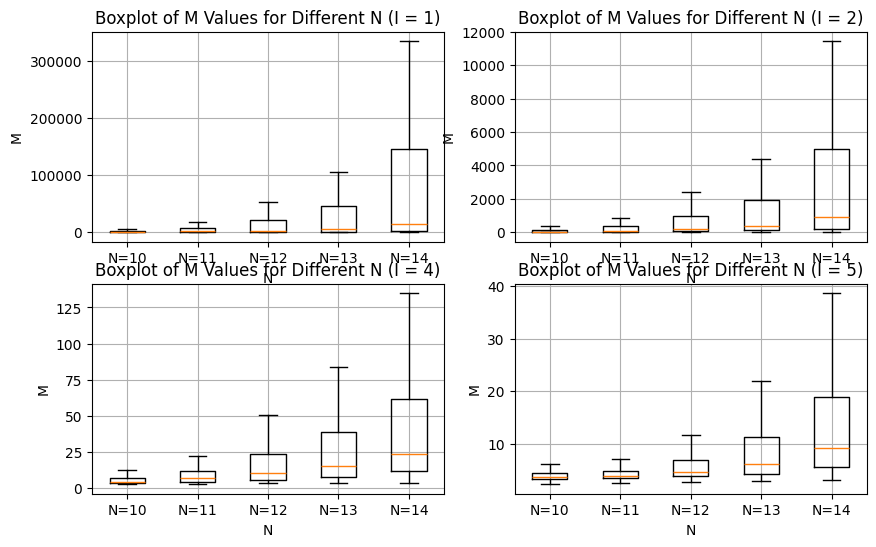

In [9]:
num_samples = 500  # Number of samples to run
N_values = range(10, 15)  # Different values for N
I_values = [1, 2, 4, 5]  # Different values for I (to apply the code to multiple I)

# Calculate the grid size (square-like)
num_plots = len(I_values)
rows = int(math.ceil(math.sqrt(num_plots)))
cols = int(math.ceil(num_plots / rows))

# Prepare the figure for subplots arranged in a square
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

# Flatten the axes array to easily index for plotting
axes = axes.flatten()

# Collect M values for different I
for idx, I in enumerate(I_values):
    M_values_all = []
    
    for N in N_values:
        M_values = []
        for _ in range(num_samples):
            p = np.random.uniform(0, 1, N)  # Generate random probabilities p
            sampler = rejection_sampler(p, I)
            M_values.append(sampler.M)
        M_values_all.append(M_values)

    # Create a boxplot for each I on the corresponding subplot
    ax = axes[idx]
    ax.boxplot(M_values_all, labels=[f'N={N}' for N in N_values], showfliers=False, showmeans=False)
    ax.set_title(f'Boxplot of M Values for Different N (I = {I})')
    ax.set_ylabel('M')
    ax.set_xlabel('N')
    ax.grid(True)

#### Evolution of M with respect to I and $p$

Our intuition told us that the evolution of $M$ would be extremly dependent on the $p_i$s. Indeed if we take the edge case where $I$ $p_i$s are equal to 1 and the rest are 0, the sampling should be immediate as its deterministic, on the other hand if, for a given $I$, all the $p_i$s tended to be near 1, it would take a long time before accepting a sample.

To see how, $M$ evolved with respect to $I$ and $p$ we thus traced, for a fixed $p$, $M(I)$. This graphic looked like a smile and after calculation its lowest point always seemed near $\sum_i p_i$. Below, you can see a close up of this graphic with the added indication of $\sum_i p_i$.

In [10]:
N = 17
p = np.random.uniform(0,1,N) 
sum_p = p.sum()
values =[]
for i in range(N-1):
    values.append(rejection_sampler(p,i+1).M)
    

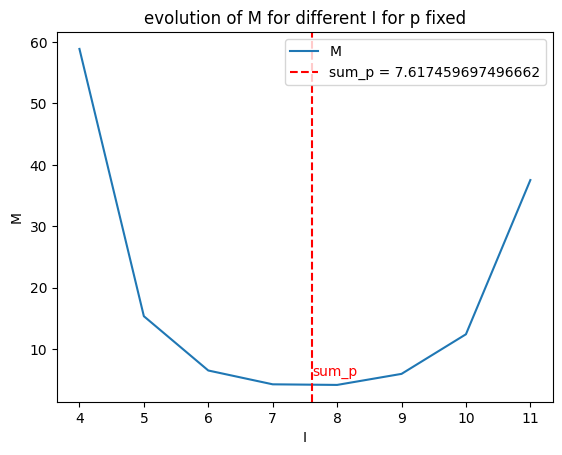

In [11]:

x_values = np.arange(1, N)  # x values start from 1 and go up to N-1
l = 4  # Example value for l

# Filter values where |x - a| < l
filtered_indices = np.abs(x_values - sum_p) < l
filtered_x_values = x_values[filtered_indices]
filtered_values = np.array(values)[filtered_indices]

# Create a line plot for the filtered series
plt.plot(filtered_x_values, filtered_values, label='M')

plt.axvline(x=sum_p, color='r', linestyle='--', label=f'sum_p = {sum_p}')
plt.text(sum_p, min(filtered_values)+1, 'sum_p', color='r', ha='left', va='bottom', fontsize=10)
# Add labels and title
plt.xlabel('I')
plt.ylabel('M')
plt.title('evolution of M for different I for p fixed')
plt.legend()

# Show the plot
plt.show()


## Question 2

Implementation of the algorithm.This exact algorithm samples from $CB(p,I)$ using the chain rule, by sequentially sampling each marginal variable one at a time.

In [12]:
N = 10
I = 4
p = np.random.uniform(0, 1, N)
sampler = exact_sampler(p, I)
sampler.sample_generator(1000)
p_value = sampler.chi_squared_adequation()

Pour le test du Chi2 avec hypothèse nulle H0 = 'notre sample suit une loi Conditionnal Bernoulli de paramètres (p,I)'
statistique du chi2 : 217.2949016258891
p-valeur : 0.3325149458674575
l'hypothèse nulle n'est pas rejeté à 10%


In [13]:
# class exact_sampler(sampler):
#     def __init__(self, p, I):
#         super().__init__(p, I)
#         self.q = self._compute_q()
#         pass
    
#     def _compute_q(self, N = None, I = None):
#         if I is None:
#             I = self.I
#         if N is None:
#             N = self.N
        
#         q = np.zeros((I+1,N))
        
#         for n in range(N):
#             q[0][n] = np.prod( 1 - self.p[n:])
        
#         q[1][N - 1] = self.p[N - 1]
        
#         for n in range(N - 2, -1, -1):
#             for i in range(1, min(I, N - n) + 1):
#                 q[i][n] = self.p[n] * q[i - 1][n + 1] + (1 - self.p[n]) * q[i][ n + 1 ]
        
#         return q
    
#     def _sample_one(self):
#         X = np.zeros(self.N, dtype = int)
#         i_n_min_1 = 0
#         for n in range(self.N - 1):
#             prob = self.p[n] * self.q[self.I - i_n_min_1 - 1][n+1] / self.q[self.I - i_n_min_1][n]
#             if np.random.rand() <= prob:
#                 X[n] = 1
#                 i_n_min_1 += 1
#                 if i_n_min_1 == self.I:
#                     break
#         if i_n_min_1 != self.I:
#             X[-1] = 1
#         return X

The construction of the matrix in our ‘sample_conditional_bernoulli’ function is of size $O(N^2)$. Indeed, we know that $I \alpha N$ at most (because $I \le \frac N2$) and so, the double loop is indexed on $\{1,... N-2\}$, and then on $\{1,...,I\}$ ($I$ proportional to $N$) in the "best" case and in the "worst" case, the second loop is repeated $N-1$ times. Thus, the complexity of this loop is $O(N^2)$.

For the second operation of the algorithm, we just get a loop on $\{1, \ldots, n\}$, thus we get a complexity of $O(N)$.

Therefore, we can conclude that the complexity is in order $O(N^2) + O(N) = O(N^2)$.

## Question 3

We now implement a Markov Chain Monte Carlo (MCMC) algorithm to sample from the conditional Bernoulli distribution $\mathrm{CB}(p, I)$ defined over the space:

$$
\Omega' := \left\{ x \in \{0,1\}^N \mid \sum_{i=1}^N x_i = I \right\}
$$

We initialize a vector $X \in \Omega'$ such that $\sum X_i = I$. For now, $X$ is <u> not random</u> (we simply permute $I$ ones and $N - I$ zeros). Indeed, $P(X_n = k| \sum_{i=1}^{N}X_i = N) = 0$ if $k \ne 1$ and $=1$ if $k=1$. Symmetrically, we obviously get $P(X_n = k| \sum_{i=1}^{N}X_i = 0) = 0$ if $k \ne 0$ and $=1$ if $k=0$.

Note that we exclude the trivial cases where $I = 0$ or $I = N$, since in those cases, the chain would be constant and there is no randomness:

- $\mathrm{CB}(p, N)$ is concentrated on the vector $(1,\dots,1)$,
- $\mathrm{CB}(p, 0)$ is concentrated on the vector $(0,\dots,0)$.

At each step, we propose a swap between:
- a random index $i_1$ where $X_{i_1} = 1$,
- and a random index $i_0$ where $X_{i_0} = 0$,

and accept this swap with probability:

$$
\alpha = \min\left(1, \frac{p_{i_0}/(1 - p_{i_0})}{p_{i_1}/(1 - p_{i_1})} \right)
$$

We denote $Y_n$ the current state of the chain, i.e. $Y_n \in \Omega'$.

Let $Y_n = x$ and let $S_1(x)$ and $S_0(x)$ be the sets of indices where $x_i = 1$ and $x_i = 0$, respectively. 

At each iteration, the algorithm:
- picks $(i_1, i_0) \in S_1(x) \times S_0(x)$,
- proposes $x' = x$ with entries $i_1 \leftrightarrow i_0$ swapped,
- accepts this move with a probability that depends **only on $x$ and $x'$**, not on earlier history.

Hence, the transition probability:

$$
P(Y_{n+1} = x' \mid Y_n = x) = q(x \to x') \cdot \alpha(x, x')
$$

In fact, we get $(Y_i)_{i \in [num iterations]}$ is a Markov Chain because $Y_i$ just depend on $Y_{i-1}$, for all $n$. 

Let's prove it. 

Let $Y_n = (Y_n^{(1)}, \ldots, Y_n^{(N)})$ a random variable to $\Omega' = \big\{x \in \Omega \mid \sum_{i=1}^Nx_i = I \big\}$ and $i \in [N]$. Let also the set $I_n \in [N]$ which represent the index $(i)$ where $Y_i^{(i)} = 1$, this set <u>just depend on $Y_i$</u>.

Let $i \in [N], k$ an integer :

\begin{align*}
    P(Y_{k+1}^{(i)} = 1)&=P(Y_{k}^{(i)} = 0)[P(Y_{k+1}^{(i)} = 1| Y_{k}^{(i)} = 0)] + P(Y_{k}^{(i)} = 1)[P(Y_{k+1}^{(i)} = 1| Y_{k}^{(i)} = 1)]\\
    &= \frac{N-I}{N}[1-\frac{1}{N-I}\min(1, \sum_{j\in I_n} \frac{1-p_i}{1-p_j})] + \frac{I}{N}[1-P(Y_{k+1}^{(i)} = 0| Y_{k}^{(i)} = 1)] \\
    & = \frac{N-I}{N}[1-\frac{1}{N-I}\min(1, \sum_{j\in I_n} \frac{1-p_i}{1-p_j})] + \frac{I}{N}[1-\frac 1I \min(1, \frac{\sum_{i \in I_n^c}1-p_j}{1-p_i})]
\end{align*}

(Note that we could just left the value $P(Y_{k}^{(i)} = 0)$ to show the property)

With the same reasoning on $P(Y_{k+1}^{(i)}=0)$, we can conclude that ($Y_i$) is a Markov chain, because it just depend on the previous value of $Y_{k}$. 

So, $(Y_i)$ does depend only on the **current state** $x = Y_n$.  


Therefore, the process $(Y_n)_{n\geq 0}$ satisfies the **Markov property**:

$$
\mathbb{P}(Y_{n+1} \mid Y_n, Y_{n-1}, \dots, Y_0) = \mathbb{P}(Y_{n+1} \mid Y_n)
$$

- The MCMC algorithm uses **local proposals** (1-to-0 and 0-to-1 swaps),
- The chain is **Markovian** by construction,

We can now use this chain to sample approximately from the conditional Bernoulli distribution $\mathrm{CB}(p, I)$. (See the proof below)


<!-- ---

Let's implement the MCMC (Markov Chain Monte Carlo).

For this, we initialize a vector $X$ which respect the condition $\sum_{i=1}^{N}X_i = I$ (for the moment, X is NOT random). After, if I isn't equal to $0$ or $N$ (because there is no random with that configuration), indeed, $P(X_n = k| \sum_{i=1}^{N}X_i = N) = 0$ if $k \ne 1$ and $=1$ if $k=1$. Symmetrically, we obviously get $P(X_n = k| \sum_{i=1}^{N}X_i = 0) = 0$ if $k \ne 0$ and $=1$ if $k=0$.

Afterward, we just "swap" the different element of our vector $X$ with probability "$\min(1,\frac{w_{i_0}}{w_{i_1}})$" like it is indicated in the paper.

In this algorithm,
$(Y_i)_{i \in [num iterations]}$ is a Markov Chain because $Y_i$ just depend on $Y_{i-1}$, for all $n$. Let's prove it. Let $Y_n = (Y_n^{(1)}, \ldots, Y_n^{(N)})$ a random variable to $\Omega' = \big\{x \in \Omega \mid \sum_{i=1}^Nx_i = I \big\}$ and $i \in [N]$. Let also the set $I_n \in [N]$ which represent the index $(i)$ where $Y_i^{(i)} = 1$, this set <u>just depend on $Y_i$</u>.

Let $i \in [N], k$ an integer :

\begin{align*}
    P(Y_{k+1}^{(i)} = 1)&=P(Y_{k}^{(i)} = 0)[P(Y_{k+1}^{(i)} = 1| Y_{k}^{(i)} = 0)] + P(Y_{k}^{(i)} = 1)[P(Y_{k+1}^{(i)} = 1| Y_{k}^{(i)} = 1)]\\
    &= \frac{N-I}{N}[1-\frac{1}{N-I}\min(1, \sum_{j\in I_n} \frac{1-p_i}{1-p_j})] + \frac{I}{N}[1-P(Y_{k+1}^{(i)} = 0| Y_{k}^{(i)} = 1)] \\
    & = \frac{N-I}{N}[1-\frac{1}{N-I}\min(1, \sum_{j\in I_n} \frac{1-p_i}{1-p_j})] + \frac{I}{N}[1-\frac 1I \min(1, \frac{\sum_{i \in I_n^c}1-p_j}{1-p_i})]
\end{align*}

(Note that we could just left the value $P(Y_{k}^{(i)} = 0)$ to show the property)

With the same reasoning on $P(Y_{k+1}^{(i)}=0)$, we can conclude that ($Y_i$) is a Markov chain, because it just depend on the previous value of $Y_{k-1}$. -->

In [14]:
def mcmc_conditional_bernoulli(p, I : int, num_iterations : int):
    p = np.array(p)
    N = len(p)
    # Let's make a X which respect the constraint sum X_i = I
    X = np.zeros(N, dtype=int)
    X[:I] = 1
    np.random.shuffle(X)
    odds = p / (1 - p)
    S0 = list(np.where(X == 0)[0])
    S1 = list(np.nonzero(X)[0])
    
    for nb_iter in range(num_iterations):
        # random selection of 1 and 0
        np.random.shuffle(S0)
        np.random.shuffle(S1)

        # let's take a random element of our index_0/1
        i = S1.pop()
        j = S0.pop()

        # Compute the probability of acceptance
        acceptance_prob = min(1, odds[j] / odds[i])

        # reject or acceptance's swap
        if np.random.rand() < acceptance_prob: # "accept with probability acceptance_prob"
            X[i], X[j] = 0, 1
            S0.append(i)
            S1.append(j) 
        else : #restores origninals values else
            S0.append(j)
            S1.append(i)

    return X

In [15]:
#test
x = mcmc_conditional_bernoulli([1/2 for i in range(1_000)],497, 10_000) 
np.count_nonzero(x)

497

#### Why does this algorithm works ? 

We already proved that $(Y_i)$ is a Markov Chain to $\Omega'$. Let's suppose that $(Y_n) \sim h$, we have $\pi$ the target probability density of $(X_1, \ldots X_N| \sum_{i=1}^{N}X_i = I)$. To apply the Metropolis Hastings algorithm, we need to check out the conditions :

- (1) $(Y_i)$ is ergodic (irreducible, recurrent, positive, aperiodic) 

- (2) reversibility : for all $x,y \in \Omega', h(x|y) = h(y|x)$, and thus, show that for all $x,y \in \{0,1\}$, we have $\pi(x)h(x|y) = \pi(y)h(y|x)$

With the Metropolis-Hasting presented below, when (1) and (2) are proven, and using the ergodic theorem we will have shown that $(Y_i)$ converge in law to $CB(p,I)$ because $\pi$ is the density of $CB(p,I) $


the **Markov chain** $(Y_i)_{i \geq 0}$ on $\Omega'$ with:

- Initial state $Y_0 \in \Omega'$, sampled uniformly.
- At each iteration $i$, choose a pair $((i,j))$ such that:
  - $j1 \in S_1(Y_i) $ (i.e., $ Y_i[j1] = 1 $),
  - $j0 \in S_0(Y_i) $ (i.e., $ Y_i[j0] = 0 $),
- Propose a **swap**: define $(Y_i')_{i \ge 0}$ by exchanging $Y_i[j0] \leftrightarrow Y_i[j1]$.
- Accept $Y_i'$ with probability:

$$
\boxed{
\alpha(Y_i, Y_i') = \min\left(1, \frac{\pi(Y_i')}{\pi(Y_i)}\right) = \min\left(1, \frac{\text{odds}_{j0}}{\text{odds}_{j1}} \right)
}
\quad \text{where } \text{odds}_{j0} := \frac{p_{j0}}{1 - p_{j0}}
$$

Then, $Y_{i+1} = Y_i'$ with probability $\frac{p_{j0}}{1 - p_{j1}}$ and $Y_{i+1} = Y_i$ elsewhere.


And thus, if we proved (1) and (2), we we proved the efficiency of our algorithm thanks to Metropolis Hastings which ensures us that $Y_i \overset{\text{(d)}}{\underset{i \to \infty}{\longrightarrow}} \pi $.


<u> Proof :</u>

- (1) Because $N$ is finite, $\Omega'$ is also finite and $(Y_i)_{i \ge 0}$ is a Markov chain irreducible (clearly, because, all the state of $\Omega'$ are available and communicate) to $\Omega'$ finite. Thus we can say that ($Y_i$) is also recurrent and positive. Furthermore, for all state $x \in \Omega'$, we can find a period stay to this stat with probability not null, and thus, our chain $(Y_i)_{i \ge 0}$ is aperiodic. Thus $(Y_i)_{i \ge 0}$ is an ergodic Markov Chain and so does converge to it's invariant probability $\pi$.

- (2) $h$ is the probability density of $(Y_i)_{i \ge 0}$, because the problem is symmetrical, that is clear that for all $x,y \in \Omega'$, we get 

$$h(x|y) = P(Y_{k+1} = x|Y_k = y) = P(Y_{k+1} = y|Y_k = x) = h(y|x)$$

Thus, because $\pi(x)$ is the density of $X_1, \ldots, X_n | \sum_{i=1}^nX_i=I$, we get 

$$\pi(x)\alpha \frac{dP_{X_1, \ldots, X_n}(x,I)}{d \mu \otimes \mu} \alpha \Pi_{i=1}^N p_i^{X_i}(1-p_i)^{1-X_i} = \Pi_{i=1}^N (\frac{p_i}{1-p_i})^{X_i}(1-p_i) = \Pi_{i=1}^N(1-p_i) \times \Pi_{i=1}^N (\frac{p_i}{1-p_i})^{X_i} \alpha \Pi_{i=1}^N (\frac{p_i}{1-p_i})^{X_i} =  \Pi_{i=1}^N (\text{odds}_i)^{X_i}$$

 (with $\mu$ the counting measuring). So, we can now conclude because let $x,y \in \Omega'$, we get 

\begin{align*}
    \pi(x)h(x|y) &= \pi(y)h(y|x)\\
    \iff \pi(x)&=\pi(y)\\
    \iff \frac{p_i^{X_i}(1-p_i)^{1-X_i}}{p_i^{X_i}(1-p_i)^{1-X_i}} &= 1
\end{align*}

What is True, so, by the explanation after (1) and (2) in the previous markdown, we showed why this algorithms works. Thus we well have 

$$\boxed{Y_i \overset{\text{(d)}}{\underset{i \to \infty}{\longrightarrow}} \pi} $$

According to the previous statement, we get $(Y_i)$ converges in distribution to $\pi$, the **unique stationary distribution**.

- The chain moves **only within the constrained set**  $\Omega'$.
- Each transition corresponds to swapping a 1 and a 0 — preserving the total number of 1's.
- The **odds ratios** act as importance weights that guide the chain toward configurations favored by \( p \).
- The Markov chain thus **explores the correct target distribution** over time.

### How to asses the mixing of our chain $(Y_i)$ ?


#### first strategy 




To evaluate the mixing of our Chain, and so, know if $(Y_i)$ visit well all the possible states, we use a **coupling-based strategy**. This permit to evaluate the meeting time of two chain $(Y_i), (\tilde Y_i)$ and thus, determine the level of mixing of our algorithm. $ (\tilde Y_i)$ start in an arbitrary state, different from $(Y_i)$. And then, compute the minimum time of meeting of those two chain. The main purpose of the paper is about a non identical distribution of $(p_1, \ldots p_N)$ thus we'll compute the meeting time in this situation.

The main goal here is to assess the velocity of convergence of $(Y_i)$ with our mcmc algorithm.

To explain our approach, this algorithm is based on the statement : if two copy of Markov chain $ (Y_i)_{i \ge 1}$  and $ (\tilde Y_i)_{i \ge 1}$ evolve together but from different states, and end up meeting, we can deduce that one of them is near of the other, and thus, there are near there limit law $\pi$. We already proved why our Markov chain is converging to the conditional Bernoulli law, according to the Metropolis Hastings algorithm, so we can use the convergence of our two Markov chain.


Moreover, we can arg a little bit more mathematically, if we the state that 

- $ (Y_i)$, starting from an arbitrary state $ x \in \Omega'$,
- $ (\tilde{Y}_i) $, starting from a different state $ \tilde{x} \in \Omega'$ at **Hamming distance 2** from $( x )$.

We then run both chains simultaneously using a **maximally coupled transition kernel**, and we record the **first time** they meet (i.e., become equal). This time is called the **meeting time**, denoted :

$$\boxed{\tau := \inf\big\{ t \ge 1 \mid Y_t = \tilde Y_t \big\}}$$ 

This approach is based on the fundamental coupling inequality:

$$\lVert \text{Law}(Y_t) - \pi \rVert_{\mathrm{TV}} \leq \mathbb{P}(Y_t \neq \tilde{Y}_t)$$

Moreover, this probability is estimated by averaging over multiple simulations:

$$ \{\omega \mid Y_t(\omega) \neq \tilde{Y}_t(\omega) \}= \{\omega \mid \tau(\omega) > t \}  \quad \implies \quad \mathbb{P}(Y_t \neq \tilde{Y}_t) = \mathbb{P}(\tau > t) $$

In practice, we generate many coupled pairs $(Y_i, \tilde{Y}_i)$, compute the corresponding meeting times $( \tau_i )$, and choose the smallest time $ t$ such that:

$$\frac{1}{M} \sum_{i=1}^M \mathbf{1}_{\{\tau_i > t\}} \leq \varepsilon$$

Note that here, $\tau_i$ are deterministic, (after computing), to avoid an abuse of language, we can say this is "knowing $\tau_i$". In other word :

$$\lVert \text{Law}(Y_t))-\pi \rVert_{TV}  \le P(Y_t \ne \tilde Y_t) \le \mathbb{E}(\mathbb{1}_{d^{(t)} > 0}) = P(d^{(t)} > 0) = P(\tau >t)$$


This procedure helps assess how fast two initially distinct trajectories "forget" their initial state and converge to the same stationary distribution, providing insight into the convergence rate of the algorithm under non-uniform probability vectors $p_1 \ldots p_N$

In [16]:
def swap_mcmc(x, y, p):
    """
    return the common swap of x,y like the function mcmc_conditional_bernoulli for just one iteration.
    That function DOES NOT WORKS if I=N or I=0, but in this case, there is no need to check the mixing. 
    """
    x, y = x.copy(), y.copy()
    odds = p / (1 - p)
    # Making the different set presented in 2.2
    S0_x = list(np.where(x == 0)[0])
    S1_x = list(np.nonzero(x)[0])
    S0_y = list(np.where(y == 0)[0])
    S1_y = list(np.nonzero(y)[0])
    if len(S0_x) == 0 or len(S1_x) == 0 or len(S0_y) == 0 or len(S1_y) == 0:
        raise ValueError("Invalid swap set: one of the chains has I = 0 or I = N.")

    # Maximal coupling for i0
    common_S0 = list(set(S0_x) & set(S0_y)) 
    alpha0 = min(len(common_S0) / len(S0_x), len(common_S0) / len(S0_y))
    # Choose a random i, in common S_0, more we have commmon values, more we would choose them
    if len(common_S0) > 0 and np.random.rand() < alpha0:
        i0 = np.random.choice(common_S0) 
        j0 = i0
    else:
        diff_x = list(set(S0_x) - set(S0_y))
        diff_y = list(set(S0_y) - set(S0_x))
        i0 = np.random.choice(diff_x)
        j0 = np.random.choice(diff_y)

    # Maximal coupling for i1, same as the previous loop
    common_S1 = list(set(S1_x) & set(S1_y))
    alpha1 = min(len(common_S1) / len(S1_x), len(common_S1) / len(S1_y))
    if len(common_S1) > 0 and np.random.rand() < alpha1:
        i1 = np.random.choice(common_S1)
        j1 = i1
    else:
        diff_x = list(set(S1_x) - set(S1_y))
        diff_y = list(set(S1_y) - set(S1_x))
        i1 = np.random.choice(diff_x)
        j1 = np.random.choice(diff_y)

    u = np.random.rand()
    if u < min(1, odds[i0] / odds[i1]):
        x[i0], x[i1] = 1, 0
    if u < min(1, odds[j0] / odds[j1]):
        y[j0], y[j1] = 1, 0

    return x, y

def initial_state_hammer(I : int, N : int):
    """ 
    generate two random vectors x,y which follow x_1+ ... + x_N = I, y_1+ ... + y_N =I AND d(x,y) = somme 1(x_i != y_i) = 2
    """
    x = np.array([1]*I + [0]*(N-I))
    np.random.shuffle(x)

    idx_1 = np.where(x == 1)[0]
    idx_0 = np.where(x == 0)[0]
    i1 = np.random.choice(idx_1)
    i0 = np.random.choice(idx_0)

    y = x.copy()
    y[i1], y[i0] = 0, 1

    return x,y
    
def meeting_time(epsilon : float, M : int, I : int, p, L=1):
    """
    Let L be the lag, epsilon the error, M the number of iteration, I like before
    """
    p = np.array(p)
    N = len(p)
    meeting_time = []
    
    for _ in range(M) :
        x,y = initial_state_hammer(I,N)
        tau = 0
        while True :
            x,y = swap_mcmc(x,y,p)
            tau += 1
            if np.array_equal(x, y): 
                meeting_time.append(tau)
                break
    t = 0
    #print(np.mean(meeting_time), np.max(meeting_time), np.min(meeting_time))
    while True :
        total_variation_t = np.mean([max(0, np.ceil((tau_i - L - t) / L)) for tau_i in meeting_time])
        if total_variation_t <= epsilon :
            return t
        t +=1

def probability_generator(N : int): 
    p = np.array([np.random.uniform(0,1) for _ in range(N)])
    return p



In [17]:
#test : samples = [X.copy()]  # Collect samples 

p = probability_generator(100)

meeting_time(epsilon=0.01,M=500,I=45,p=p) 



557

Thus, we checked that the mixing time is approximately in order $N \log(N)$. Let's see it with a plot.

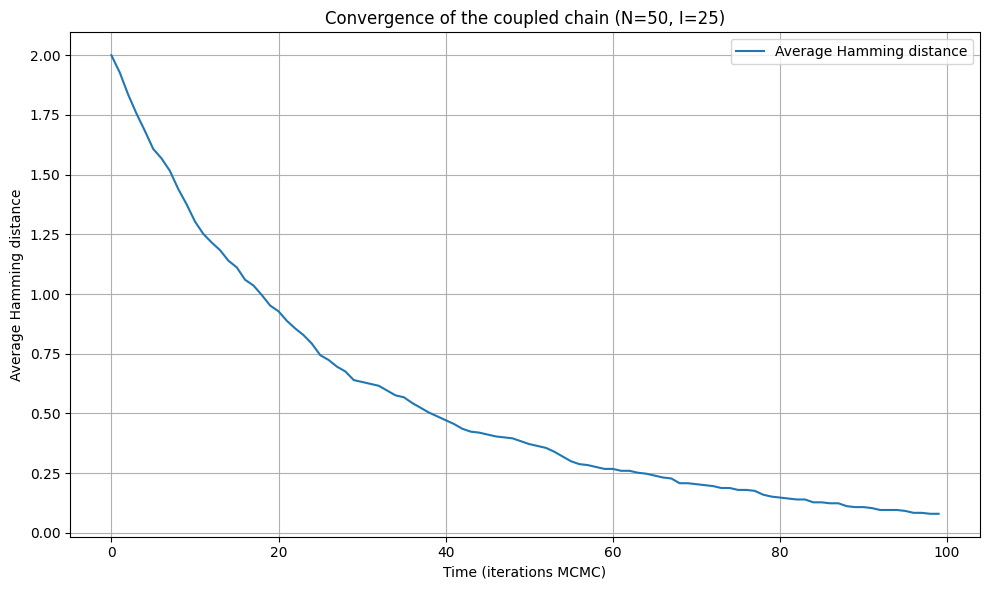

In [18]:

def hamming_distance(x, y):
    return np.sum(x != y)

def simulate_convergence(I, N, p, M=500, max_steps=100): # max step to avoid infinite loop
    distances = np.zeros((M, max_steps))

    for m in range(M):
        x, y = initial_state_hammer(I, N)
        for t in range(max_steps):
            distances[m, t] = hamming_distance(x, y)
            if np.array_equal(x, y):
                # stay at 0 after meeting
                distances[m, t:] = 0
                break
            x, y = swap_mcmc(x, y, p)

    # Mean on the M-trajectory
    mean_dist = distances.mean(axis=0)
    return mean_dist

# Parameters
N = 50
I = 25
p = probability_generator(N)
M = 500       
max_steps = 100

# Simulation
mean_hamming = simulate_convergence(I, N, p, M=500, max_steps=max_steps)


plt.figure(figsize=(10, 6))
plt.plot(mean_hamming, label='Average Hamming distance')
plt.xlabel("Time (iterations MCMC)")
plt.ylabel("Average Hamming distance")
plt.title(f"Convergence of the coupled chain (N={N}, I={I})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Let's see a boxplot to understand the distribution and the reliability of that algorithm 

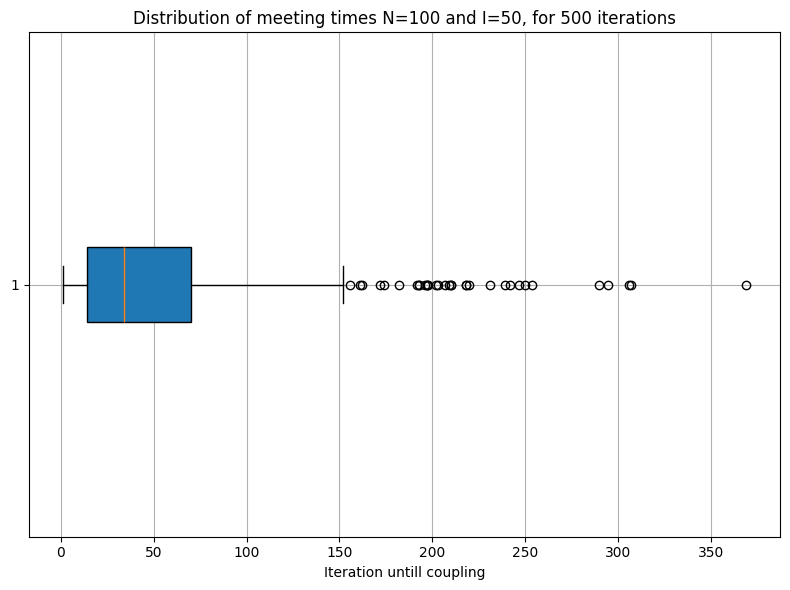

In [19]:
def get_meeting_times(I, N, p, M=500, max_steps=1000): # max step to avoid infinite loop
    meeting_times = []
    for _ in range(M):
        x, y = initial_state_hammer(I, N)
        for t in range(max_steps):
            if np.array_equal(x, y):
                meeting_times.append(t)
                break
            x, y = swap_mcmc(x, y, p)
        else:
            meeting_times.append(max_steps)  
    return meeting_times

# Boxplot
I = 50
N = 100
M = 500
p = probability_generator(N)

meeting_times = get_meeting_times(I=I, N=N, p=p,)
plt.figure(figsize=(8, 6))
plt.boxplot(meeting_times, vert=False, patch_artist=True)
plt.title(f"Distribution of meeting times N={N} and I={I}, for {M} iterations")
plt.xlabel("Iteration untill coupling")
plt.grid(True)
plt.tight_layout()
plt.show()


Well, we notice that in average, for $N=100$, we get a meeting time lower than $100\times \log(100)$ this is an efficient mixing !  

#### Second strategy 

Though we already have answered this question, we can still propose another way to compute the mixing of the algorithm. The main "problem" with the previous method is the constraint $\mathbb X_{\text{adj}}$ where the Hammer distance is bounded on two. This is actually not a problem, because the first method is mathematically verified, but we want to propose a more "intuitive" method. We propose another version where we have $(x)^{(t)}$, $(\tilde x)^{(t)}$ with $x^{(0)} \in \Omega'$ and $\tilde x \sim CB(p,I)$, here we will apply the same logical, the same changes for those two chain, and compute the average time meeting. 

The "advantage" of that method is to not constraint us to this $\mathbb X_{\text{adj}}$ but the drawbacks is that it is more expansive to compute. We also propose another way to compute the distance, more easy to compute. $P(\tau>t) = \hat d_{TV} $ here, and it is totally okay according to the inequality above.


Mathematically, to explain our method : 

Let:
- $x^{(0)} \in \Omega'$ be an arbitrary initial state such that $\sum x_i = I$,
- $\tilde{x}^{(0)} \sim \text{CB}(p, I)$, drawn from the true target distribution.

Then, we evolve both chains $(x^{(t)})_{t \geq 0}$ and $(\tilde{x}^{(t)})_{t \geq 0}$ **using the same coupled transition kernel** (as before), and record the **first time $\tau$ such that $x^{(\tau)} = \tilde{x}^{(\tau)}$**.

This method is simpler to implement, since we do not require the chains to be initialized at a specific distance, and the coupling mechanism is the same.

According to the coupling inequality, we still have:

$$
\lVert \text{Law}(x^{(t)}) - \pi \rVert_{TV} \leq \mathbb{P}(x^{(t)} \neq \tilde{x}^{(t)}) = \mathbb{P}(\tau > t)
$$

So by estimating $\mathbb{P}(\tau > t)$ empirically, we directly obtain an **upper bound** on the total variation distance to stationarity.

Letting $\hat{\tau}_1, \dots, \hat{\tau}_M$ be $M$ i.i.d. meeting times, we approximate:

$$
\hat{d}_{TV}(t) := \frac{1}{M} \sum_{i=1}^M \mathbf{1}_{\hat{\tau}_i > t}
$$

and return the **smallest $t$ such that $\hat{d}_{TV}(t) \leq \varepsilon$**.


In [20]:
def initial_state(I : int, N : int):
    """ 
    generate random vector x which follow x_1+ ... + x_N = I
    """
    x =np.array([1]*I + [0]*(N-I))
    np.random.shuffle(x)
    return x

def alternative_mcmc_meeting_time(epsilon : float, M : int, I : int, p):
    """
    Alternative way to compute the mixing of our chain, that's normal that the meeting time is larger than the previous method, we do not restrein us to the case where 
    the Hammer distance is equal to two. 
    """
    p = np.array(p)
    N = len(p)
    meeting_time = []
    for _ in range(M):
        tau = 0 
        x = initial_state(I,N)
        sampler = rejection_sampler(p,I)
        sampler.naive_sample()
        y = sampler.sample
        while True :
            x,y = swap_mcmc(x,y,p)
            tau += 1
            if np.array_equal(x, y): 
                meeting_time.append(tau)
                break
    t = 0
    while True:
        total_variation_t = np.mean([tau > t for tau in meeting_time])
        if total_variation_t <= epsilon:
            return t
        t += 1
        

In [ ]:
# Let's try our alternative algorithm

p = probability_generator(100)

alternative_mcmc_meeting_time(epsilon=0.01,M=500,I=50,p=p) 


636

Obviously, like we would expect, the meeting time is much larger. 

We can in other hand identify different pros of our method : our algorithm is general, conceptually clean, with no artificial distance constraint subject to requiring a sampling from $\text{CB}(p,I)$, which can be **computationally costly**... 

Indeed, meeting times may be larger on average than in the adjacent initialization case.. 

#### Third strategy 

Finally, we present a third and more theoretically grounded method for estimating the mixing time of our Markov chain.  
We implement **Algorithm 1** from the paper _"Estimating Convergence of Markov Chains with L-Lag Couplings"_ by Biswas, Jacob, and Vanetti (2019), which provides a way to estimate the **total variation distance** of a Markov chain.


We aim to estimate the quantity:

$$
d_{\text{TV}}(\mathcal{L}(x_t), \pi)
$$

where:
- $\mathcal{L}(x_t)$ is the law of the Markov chain at time $t$,
- $\pi$ is the target distribution (here, the conditional Bernoulli law $\text{CB}(p, I)$).

Since we do not know $\mathcal{L}(x_t)$ explicitly, we **construct a coupling** between two chains:
- $(x_t)$, evolving from an arbitrary initial state in $\Omega'$,
- $(y_{t-L})$, a second chain started from another state and updated in parallel,
with a **temporal lag** $L$ between them.

So to compute it, we can say that while $(x_t) \ne (y_{t-L})$, Law $(x_t) \ne \pi$. So, we just have to compute the meeting times and look at them.

Mathematically, we simulate the two chains with lag $L$ using the same coupled kernel, and define the **meeting time** $\tau^{(L)}$ as:

$$\tau^{(L)} = \inf\{t \ge L \mid x_t = y_{t - L} \}$$

according to the paper, we know that 

$$d_{\text{TV}}(\mathcal{L}(x_t), \pi) \le \mathbb{E}[\max(0, \lceil \frac{\tau^{(L)}-L-t}{L}\rceil)] $$

This estimator is **guaranteed to upper-bound** the variation distance and is **monotonically decreasing** in $t$.  
It provides a **rigorous and practical tool** to quantify convergence.

with $\tau^{(L)}$ the meeting time for lag $L$. Thus, this is obvious that it is decreasing with $t$. This method is for us better than the previous, indeed, the second method is very expensive to compute. This below algorithm is based on theoretical result guaranteed and is not slow to compute. 

In [23]:
def algorithm_1_L_lag_coupling(L, M, I, p):
    """
    Implementation of the first algorithm of the paper.
    Compute and return the meeting time τ^{(L)}
    """
    p = np.array(p)
    N = len(p)
    meeting_times = []

    for _ in range(M):
        # Initialisation
        x = initial_state(I, N)  # X_0
        X_chain = [x]
        for _ in range(L):  # Génerate X_1,...,X_L
            x = swap_mcmc(x, x, p)[0]
            X_chain.append(x)

        y = initial_state(I, N)  # Y_0

        t = L
        while True:
            x_new, y_new = swap_mcmc(X_chain[-1], y, p)
            X_chain.append(x_new)
            y = y_new
            if np.array_equal(x_new, y):
                meeting_times.append(t)
                break
            t += 1

    return meeting_times

In [24]:
def estimate_total_variation(tau_L_list, L, t_max):
    """
    Estimate the total variation distance d_{TV}(π_t=law(x_t), π)
    from meeting times τ^{(L)} for all t ≤ t_max 

    Return : table numpy with d_TV estimate for t = 0, ..., t_max
    """
    tau_L = np.array(tau_L_list)
    M = len(tau_L)
    d_tv = []

    for t in range(t_max + 1):
        # for each t, we compute the contribution max(0, ceil((τ - L - t) / L)) for each trajectory
        individual_bounds = []
        for tau in tau_L:
            bound = (tau - L - t) / L
            bound = max(0,np.ceil(bound))
            #print(bound)
            individual_bounds.append(bound)

        # empirical mean : we asses the uppper bound of d_TV(π_t, π)
        d_tv_t = np.mean(individual_bounds)
        d_tv.append(d_tv_t)

    return np.array(d_tv)


In [25]:
p = probability_generator(N=50)
meeting_times = algorithm_1_L_lag_coupling(L=1, M=500, I=25, p=p)
mean_meeting_times = np.mean(meeting_times)
print(f'average meeting time : {mean_meeting_times}')

average meeting time : 90.288


Let's show as before a histogram to see how are distributed the meeting times, for $M=500$, $I=25$ and $N = 50$.

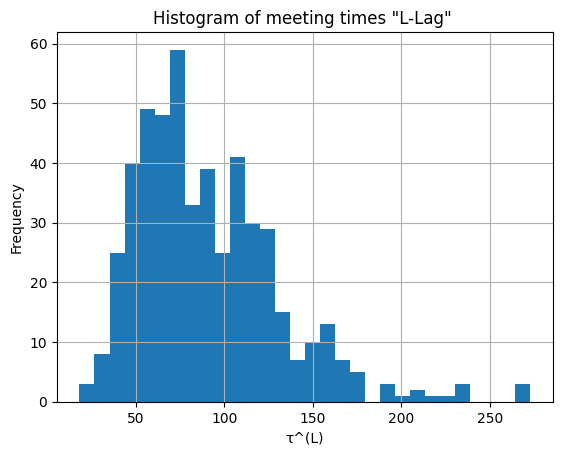

In [26]:
plt.hist(meeting_times, bins=30)
plt.xlabel("τ^(L)")
plt.ylabel("Frequency")
plt.title("Histogram of meeting times \"L-Lag\" ")
plt.grid(True)
plt.show()

And now, we'll show how is decreasing the estimated total variation with number of iteration.

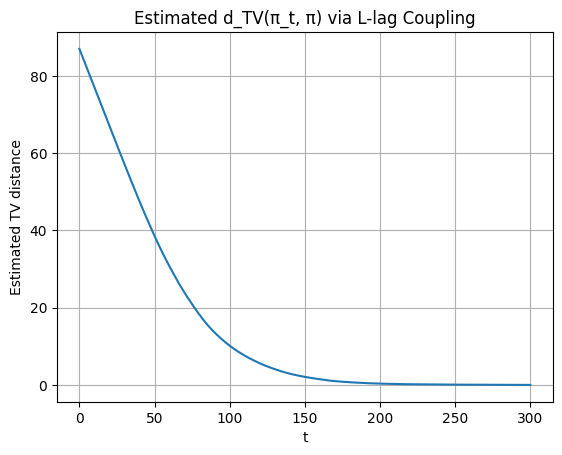

In [27]:
tau_L = algorithm_1_L_lag_coupling(L=1, M=500, I=25, p=p)
d_tv_values = estimate_total_variation(tau_L, L=1, t_max=300)

plt.plot(d_tv_values)
plt.xlabel("t")
plt.ylabel("Estimated TV distance")
plt.title("Estimated d_TV(π_t, π) via L-lag Coupling")
plt.grid(True)
plt.show()

rk: the estimated TV distance is $\mathbb{E}[\max(0, \lceil \frac{\tau^{(L)}-L-t}{L}\rceil)]$

Thus, we can also identify different pros :

- Theoretical Guarantee : Upper bound on $d_{\text{TV}}$ based on a proven inequality
- Efficient : Much faster than parallel chain couplings for high accuracy

and some cons :

-  Requires trajectory storage — One needs to keep $x_0, ..., x_t$ $\implies$ costly in memory.

## Question 4

The exact algorithm (using chain rule) can be adapted to make use of (R)QMC method. To do so, when generating the marginal variable, rather than using a uniform we use a low discrepency sequence (here we choose to implement either Sobol's sequence or Halton's sequence) with an added uniform random shift if we do a randomized quasi monte carlo.

When testing if these QMC and RQMC sampling method sample from $CB(p,I)$, still using our $\chi^2$ test we remarked that the QMC algorithm was rejected, while the RQMC was not.

In [28]:
N = 10
I = 4
p = np.random.uniform(0,1,N)
sampler = RQMC_sampler(p,I)

In [29]:
# Sampling using Sobol sequence (RQMC)
sampler.sample_generator(1024,sequence=0,RQMC = True)
p_val =sampler.chi_squared_adequation()

Pour le test du Chi2 avec hypothèse nulle H0 = 'notre sample suit une loi Conditionnal Bernoulli de paramètres (p,I)'
statistique du chi2 : 208.2385894103134
p-valeur : 0.5018598702902886
l'hypothèse nulle n'est pas rejeté à 10%


In [30]:
# Sampling using Sobol sequence (QMC)
sampler.sample_generator(1024,sequence=0,RQMC = False)
p_val =sampler.chi_squared_adequation()

Pour le test du Chi2 avec hypothèse nulle H0 = 'notre sample suit une loi Conditionnal Bernoulli de paramètres (p,I)'
statistique du chi2 : 93.15644536223556
p-valeur : 0.9999999999997891
l'hypothèse nulle n'est pas rejeté à 10%


### advantages of (R)QMC

While these implementation of sampling method do not provide quicker sampling method (as they are still in $O(N^2)$ due to the initial calculation of the matrix $q$), they should normally offer a quicker convergence rate when using them to approximate an expectation.

To test this we tried to approximate $E[X]$ where $X \sim CB(p,I)$ and traced the error $||E[X] - \overline{X}_n ||_2$ where $\overline{X}_n$ is the estimator of $E[X]$ using $X_i$ sampled from one of the three considered algorithm.

Without surprise:
 - the exact algorithm (classic monte carlo method) has an error in $O(1/ \sqrt{n})$ with $n$ the number of sample
 - both the QMC and RQMC sampling method has error in $O(n^{ \varepsilon -1})$ (with $\varepsilon \approx 0.4$ in our case)

We can note that despite the fact that the QMC sampling fail the $\chi_2$ test, it give a good result when used to approximate $E[X]$

In [31]:
L = 2048
u = lambda x:x*x
E = sampler._calculate_expectation(u)
sampler.sample_generator(L,sequence=2)
S_exact = sampler.sample
sampler.sample_generator(L,sequence=0,RQMC=False)
S_sobol = sampler.sample
sampler.sample_generator(L,sequence=0,RQMC=True)
S_rqmc = sampler.sample

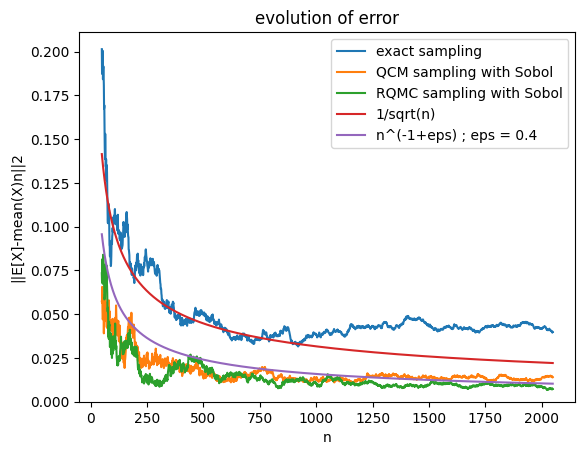

In [32]:
start = 50
eps = 0.40
x_values = np.arange(start, L + 1)

plt.plot(x_values, np.array([np.linalg.norm((E - np.mean(S_exact[:i], axis= 0))) for i in range(start,L+1)]), label='exact sampling')
plt.plot(x_values, np.array([np.linalg.norm((E - np.mean(S_sobol[:i], axis= 0))) for i in range(start,L+1)]), label='QCM sampling with Sobol')
plt.plot(x_values, np.array([np.linalg.norm((E - np.mean(S_rqmc[:i], axis= 0))) for i in range(start,L+1)]), label='RQMC sampling with Sobol')
plt.plot(x_values, 1/np.sqrt(x_values), label='1/sqrt(n)')
plt.plot(x_values, x_values**(-1+eps), label=f'n^(-1+eps) ; eps = {eps}')
plt.ylim(bottom=0)

plt.xlabel('n')
plt.ylabel('||E[X]-mean(X)n||2')
plt.title('evolution of error')
plt.legend()

# Show the plot
plt.show()
